## 19-多智能体强化学习 I
单智能体强化学习算法，其基本假设是动态环境是稳态的（stationary），即状态转移概率和奖励函数不变。<br>
多智能体条件下，环境是非稳态的，每个智能体都在改变环境，所以转移概率也可能经常变化。

* **完全中心化（fully centralized）方法：** 将多个智能体进行决策当作一个超级智能体在进行决策，即把所有智能体的状态聚合在一起当作一个全局的超级状态，把所有智能体的动作连起来作为一个联合动作，好处是环境仍然是稳态的，收敛性有保证，但是状态空间或者动作空间太大可能导致维度爆炸。
* **完全去中心化（fully decentralized）：** 假设每个智能体都在自身的环境中独立地进行学习，不考虑其他智能体的改变。每个智能体单独采用一个强化算法训练，但是环境非稳态，收敛性不能保证。

仍然定义PPO或者其他算法，在训练时，建立多个智能体，每个智能体单独用一个transition表即可。

## IPPO
完全去中心化的算法，此类算法被称为**独立学习（independent learning）**。由于对于每个智能体使用单智能体算法 PPO 进行训练，所因此这个算法叫作**独立 PPO（Independent PPO，IPPO）**算法。具体而言，这里使用的 PPO 算法版本为 **PPO-截断**，其算法流程基本上和PPO是一样的

##### 参数共享技巧--前提：同质的
值得注意的是，在训练时使用了**参数共享（parameter sharing）**的技巧，即对于所有智能体使用同一套策略参数，这样做的好处是能够使得模型训练数据更多，同时训练更稳定。
<br> 
能够这样做的前提是，两个智能体是 **同质的(homogeneous)**—即它们的状态空间和动作空间是完全一致的，并且它们的优化目标也完全一致—


### IPPO问题：无法有效合作
当智能体数量较少的时候，IPPO 这种完全去中心化学习在一定程度上能够取得好的效果，但是最终达到的胜率也比较有限。
> 这可能是因为多个智能体之间无法有效地通过合作来共同完成目标

这时候可能就需要引入更多的算法来考虑多个智能体之间的交互行为，或者使用中心化训练去中心化执行（centralized training with decentralized execution，CTDE）的范式来进行多智能体训练，


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
#from tqdm import tqdm
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

import sys
sys.path.append("./ma-gym")
from ma_gym.envs.combat.combat import Combat

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s, episode=1000, return=0.750]


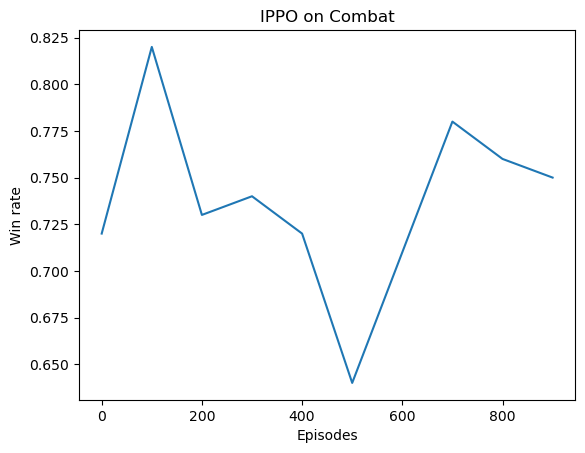

In [10]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return F.softmax(self.fc3(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        log_probs = torch.log(self.actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps,
                            1 + self.eps) * advantage  # 截断
        actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 1000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

team_size = 2
grid_size = (15, 15)
#创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)

state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n
#两个智能体共享同一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, eps,
            gamma, device)

win_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            transition_dict_1 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            transition_dict_2 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            s = env.reset()
            terminal = False
            while not terminal:
                a_1 = agent.take_action(s[0])
                a_2 = agent.take_action(s[1])
                next_s, r, done, info = env.step([a_1, a_2])            
                transition_dict_1['states'].append(s[0])
                transition_dict_1['actions'].append(a_1)
                transition_dict_1['next_states'].append(next_s[0])
                #-----------------------------------------------
                #transition_dict_1['rewards'].append(
                #    r[0] + 100 if info['win'] else r[0] - 0.1)
                #++++++++++++++++++++++++++++++++++++++++++++++
                #win条件是所有对手的健康值都为 0
                win = all(health == 0 for health in info['health'].values())
                transition_dict_1['rewards'].append(r[0] + 100 if win else r[0] - 0.1)
                transition_dict_2['rewards'].append(r[1] + 100 if win else r[1] - 0.1)
                #===============================================
                transition_dict_1['dones'].append(False)
                transition_dict_2['states'].append(s[1])
                transition_dict_2['actions'].append(a_2)
                transition_dict_2['next_states'].append(next_s[1])
                #-------------------------------------------------
                #transition_dict_2['rewards'].append(
                #    r[1] + 100 if info['win'] else r[1] - 0.1)
                transition_dict_2['dones'].append(False)
                s = next_s
                terminal = all(done)
            #----------------------------------------
            #win_list.append(1 if info["win"] else 0)
            #++++++++++++++++++++++++++++++++++++++++++
            all_opponents_defeated = all(health == 0 for health in info['health'].values())
            #使用all_opponents_defeated更新win_list
            win_list.append(1 if all_opponents_defeated else 0)
            #==========================================
            agent.update(transition_dict_1)
            agent.update(transition_dict_2)
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(win_list[-100:])
                })
            pbar.update(1)

win_array = np.array(win_list)
#每100条轨迹取一次平均
win_array = np.mean(win_array.reshape(-1, 100), axis=1)

episodes_list = np.arange(win_array.shape[0]) * 100
plt.plot(episodes_list, win_array)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()

# 中心化训练去中心化执行(CTDE)

是指在训练的时候使用一些单个智能体看不到的全局信息而以达到更好的训练效果，而在执行时不使用这些信息，每个智能体完全根据自己的策略直接动作以达到去中心化执行的效果。中心化训练去中心化执行的算法能够在训练时有效地利用全局信息以达到更好且更稳定的训练效果，同时在进行策略模型推断时可以仅利用局部信息，使得算法具有一定的扩展性。CTDE 可以类比成一个足球队的训练和比赛过程：在训练时，11 个球员可以直接获得教练的指导从而完成球队的整体配合，而教练本身掌握着比赛全局信息，教练的指导也是从整支队、整场比赛的角度进行的；而训练好的 11 个球员在上场比赛时，则根据场上的实时情况直接做出决策，不再有教练的指导。

## 环境

## gumbel-softmax

In [ ]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])[[
        np.random.choice(range(logits.shape[1]), size=logits.shape[0])
    ]],
                                       requires_grad=False).to(logits.device)
    # 通过epsilon-贪婪算法来选择用哪个动作，r是
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        for i, r in enumerate(torch.rand(logits.shape[0]))
    ])


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),
                                requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样，加上从sample_gumbel生成的噪声"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(
        logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y  # * 式（1）
    # * 减一个y再加一个y，仍然是onehot_y，也就是离散的action
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    # * 我的理解是，对于最后return的y来说，是离散的动作（独热的），但是求梯度时，
    # * 在式（1）中，由于前面detach了，没有梯度，因此只对后一个y求梯度，
    # * 这个y是来自上一个函数gumbel_softmax_sample得到的y，这样就可以反向传播了
    return y

## DDPG

In [ ]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法, 参数更新写在MADDPG中 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,
                 actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:  # *探索时，需要训练模型，gumbel_softmax可以反向传播
            action = gumbel_softmax(action)
        else:  # * 应用时，不需要训练模型，onehot_from_logits直接把连续动作离散，
               # * 无法反向传播，但是返回的结果只比gumbel_softmax少一个噪声，差别不大
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +
                                    param.data * tau)

## MADDPG

In [ ]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [
            torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in env.agents  # 未写环境导致的警告
        ]
        
        #  注意：这里的agent.take_action是DDPG算法中的
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(-1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value, target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

## 初始化参数

In [ ]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
update_interval = 100
minimal_size = 4000

observations, infos = env.reset()
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []

action_dims = [i.n for i in env.action_spaces.values()]
state_dims = [i.shape[0] for i in env.observation_spaces.values()]

critic_input_dim = sum(state_dims) + sum(action_dims)  # 总维度43

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

## 评估和训练

In [ ]:
def evaluate(maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = simple_adversary_v3.parallel_env(render_mode="human")
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs, info = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, truncated, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state, info = env.reset()
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        # actions是一个矩阵，每一行表示一个智能体的动作集
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, truncated, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done, truncated)
        state = next_state

        total_step += 1
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)

            # 👇下面这个函数的操作比较难解释，提示：输入网络的维度是状态长度，相当于特征，具体过程看后面
            def stack_array(x):
                rearranged = [[sub_x[i] for sub_x in x]
                              for i in range(len(x[0]))]
                return [
                    torch.FloatTensor(np.vstack(aa)).to(device)
                    for aa in rearranged
                ]

            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()  # 软更新来的
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(maddpg, n_episode=100)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

In [ ]:
env.close()

# 关于stack_array函数的解释

In [ ]:
import numpy as np
import torch

In [ ]:
def stack_array(x):
    rearranged = [[sub_x[i] for sub_x in x]
                    for i in range(len(x[0]))]
    return [
        torch.FloatTensor(np.vstack(aa))
        for aa in rearranged
    ]

In [ ]:
# 环境给出的状态形式，每行代表某一时刻三个智能体的观测，这里假设是随机抽了三个，即行数
x = [[np.array([1, 2]), np.array([3, 4]), np.array([3, 5])],
     [np.array([4, 2]), np.array([0, 7]), np.array([5, 5])],
     [np.array([1, 5]), np.array([4, 7]), np.array([6, 2])],]


In [ ]:
# 第一步
[[sub_x[i] for sub_x in x] for i in range(len(x[0]))]

# 其实就是转置，但是列表不能转置

In [ ]:
aa = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))][0]

In [ ]:
aa

In [ ]:
np.vstack(aa)

In [ ]:
stack_array(x)  # 把array拆了，倒数第二维变成torch.tensor
# 此时第一个输入的样本，即第一个tensor，就是该批次中，第一个智能体所碰到的全部当前状态
# 第二个tensor，就是第二个智能体碰到的全部当前状态
# 里面tensor部分就和单智能体一样了，参考后面的单智能体输出结果

## 单智能体的输出过程

In [ ]:
replay_buffer.sample(3)

In [ ]:
b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(3)
transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 
                    'rewards': b_r, 'dones': b_d, 'truncated': b_t}

In [ ]:
b_s

In [ ]:
transition_dict['states']

In [ ]:
torch.tensor(transition_dict['states'], dtype=torch.float)